# Fish trait segmentation and trait table using interactive tool to crop the fish out

This jupyter notbook will guide you to perform the analysis of fish traits
There are several sections, important to follow the notebook in the right order


1- Prediction tools
    
    a- Import
    b- Loading the model
    c- Preprocessing, prediction, visualization and save
    d- Batch processing
    
2-  Interactive cropping

    When the fish are not cropped from the image, use this part of the notebook
    1- Selcet the folder containing the fish images
    2- Use the interactive tool to select a cropping area around the fish. Do this for whole set of images contain in the folder
    3- Then apply the prediction on the whole set
    4- Create a table of trait that you can export in csv



# IMPORT

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import segmentation_models_pytorch as smp
#import albumentations as albu

import seaborn as sns
import pylab as py
import pandas as pd
import torch
from torchvision import transforms

from scripts.helper import *

# Loading Model

In [4]:
model, preprocessing_fn, CLASSES = load_pretrained_model()
DEVICE = ('cuda:4' if torch.cuda.is_available() else 'cpu')
# the pretrained model defined in the helper.py are downloaded in /home/.cache/torch/hub/checkpoints/se_resnext50...

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /home/thibault/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [6]:
# load the model weight, be sure that the model location ('saved_models/Trained_model_SM.pth') is the correct one
map_location=torch.device('cpu')
model = torch.load('saved_models/Trained_model_SM.pth', map_location=map_location)
#model = torch.load('saved_models/Trained_model_SM.pth').to(DEVICE)

/home/thibault/anaconda3/envs/trait-segmentation/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.fpn.model.FPN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/thibault/anaconda3/envs/trait-segmentation/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'segmentation_models_pytorch.encoders.senet.SENetEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/thibault/anaconda3/envs/trait-segmentation/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of c

# Preprocessing, prediction, visualization and save for a single image

1- Resize to 800x320
2- Preprocess (mainly normalization)
3- Prediction
4- visulaization
5- Save

In [ ]:
# Functions to perform the preprocessing 

plt.rcParams['figure.figsize'] = [20, 15]

def Import_image (file_path):    
    img = Image.open(file_path)
    return img

def Resize_img(img, r_width = 800, r_height = 320 ):
    ''' Resize the image to the size r_width x r_height
    Default value 800x320
    input : File_path is the location of the image(.png or .jpg)
    ouput : image resized in the form of numpy array  '''
    
    r_img = transforms.Resize((r_height, r_width))(img)
    #r_img.save('transformed_images/'+image_name)
    r_img = np.array(r_img, dtype=np.float32)
    return r_img

def Preprocessing_single_image(img_PIL):
    ''' From a image in PIL format, Resize the image to 800x320 in np.array, Normalize using the preprocessing_fn function
    and finally format the order of axis [ch, width, height]
    input : img_PIL image in PIL format
    output : image_array, numpy array with type float32 3x800x320
    '''
    img_array = Resize_img(img_PIL)
    image_array = preprocessing_fn(img_array).astype('float32')
    image_array = np.moveaxis(image_array, -1, 0)    
    return image_array

In [ ]:
# functions to perform prediction

def Traits_prediction_one_image(image_array):    
    ''' Predict the traits from a image array which should be normalize
    input: image_array image in numpy array type float32
    output: pred_mask, prediction mask from model as numpy 12x800x320
    '''
    
    # Create a 4 dimension tensor require fr the model [batch, width, height, channel]
    img_tensor = torch.from_numpy(image_array).to(DEVICE).unsqueeze(0)
    pred_mask = model.predict(img_tensor)
    pred_mask = pred_mask.squeeze().cpu().numpy().round()
    
    return pred_mask

def Traits_prediction_batch(list_array):    
    ''' Predict the traits from a image array which should be normalize
    input: image_array image in numpy array type float32
    output: pred_mask, prediction mask from model as numpy 12x800x320
    '''
    
    # Create a 4 dimension tensor require fr the model [batch, width, height, channel]
    img_tensor = torch.as_tensor(list_array).to(DEVICE)
    pred_mask = model.predict(img_tensor)
    pred_mask = pred_mask.squeeze().cpu().numpy().round()
    
    return pred_mask

In [7]:
# function to perform montage and visualization


def Create_montage(pred_mask, image_orig, legend_file='Legends.png'):
    ''' Create a montage with the original image resized and the prediction mask for the traits
    Input
    Output: PIL image
    
    '''
    # to plot the legends
    legend_img = Image.open(legend_file)
    w_legend, h_legend = legend_img.size
    ar = w_legend/h_legend
    
    new_h = pred_mask.shape[1]
    legend = legend_img.resize((int(new_h*ar), new_h), Image.ANTIALIAS)
    
    
    image_montage = get_concat_h(
        get_concat_h(
            Image.fromarray(image_orig.astype('uint8')),
            get_color_img(pred_mask, normal=False)
        ),
        legend)
        
    return image_montage

def Visualize_montage(image_montage): 
    
    plt.figure()
    plt.axis('off')
    plt.imshow(image_montage)
    

def Save_prediction(pred_mask, file_path, output_folder='segmented_images/'):
    '''
    input : 
        pred_mask = array (12,800,320) output of the prediction
        file_path = location of the original image to extract file_name
        output_folder =  location where to save the image
    '''
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    image_name = os.path.split(file_path)[-1]
    output_image_file = os.path.join(output_folder, image_name)
    get_color_img(pred_mask, normal=False).save(output_image_file)  
        
def Save_montage(image_montage, file_path, output_folder='joint_images/'):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    image_name = os.path.split(file_path)[-1]     
    output_image_file = os.path.join(output_folder, image_name)
    image_montage.save(output_image_file) 
    
 

def Predict_save(file_path, Result_folder, legend_file='Legends.png'):
    
    image_orig = Resize_img(file_path)
    image_preprocess = preprocessing_single_image(file_path)
    pred_mask = traits_prediction_one_image(image_preprocess)
    montage = Create_montage(pred_mask, image_orig)
    visualize_montage(montage)
    
    montage_folder  = os.path.join(Result_folder, 'Montage')
    Save_montage(image_montage, file_path, output_folder=montage_folder)
    
    pred_mask_folder  = os.path.join(Result_folder, 'Prediction')
    Save_prediction(pred_mask, file_path, output_folder=pred_mask_folder)

# Create working folder and select a subset of fish images

1- Create a working folder that will contain a csv file with metadata information
    
    a- Create a folder to save the traits, the montage and the traits table
    b- Create a csv file with fish images you want to analysis, take a subset from


In [8]:
os.getcwd()

'/home/thibault/Documents/Project/BGNN-trait-segmentation/pipeline'

In [9]:
#csv_name = '/home/thibaulttb/Documents/Data/Image_Metadata_GLIN.csv'
csv_name ='/home/thibault/Documents/Data/Image_Metadata_v1.1_20220207_131855.csv'
df = pd.read_csv(csv_name) 
df.head()

species = df['scientific_name'].tolist()
np.unique(species).shape

(13881,)

# Pipeline do segment the traits from folder

1- import and functions definition
2- Interactive cropping
3- Predict
4- visualize
5- Save


# Interactive cropping


In [11]:
import os
import numpy as np
import pprint
# Import the cropping widget and example images
from interactivecrop.interactivecrop import main as crop
#from interactivecrop.samples import sample_images, sample_names


In [12]:
# define several function to process the data
# This funciton should constitute the workflow

def Create_image_dict (PATH_TO_SAMPLES):
    ''' From the list of fish in the directory
    it creates dictionnary containing the imported image in PIL format
    and image_name
    '''
    
    image_list = []
    image_name_list = []
    image_dict = {}
    for filename in os.listdir(PATH_TO_SAMPLES):
        
        file_path = os.path.join( PATH_TO_SAMPLES ,filename)
        image_list.append(file_path)
        image_name_list.append(filename)
        img = Image.open(file_path)
        image_dict[filename] = img
    
    return image_list, image_name_list, image_dict
    

def get_cropped_image(image_dict, bbox_dict, file_name):
    
    img = image_dict[file_name]
    bbox = bbox_dict[file_name]
    im_crop = img.crop(bbox)
    return im_crop


def predict_from_pil_im(im_crop):
    
    # REsize the image to the correct size to apply the model ()
    image_orig = Resize_img(im_crop, r_width = 800, r_height = 320 )
    # Preprocess the image using normalization 
    image_preprocess = Preprocessing_single_image(im_crop)
    # Predict using the model
    pred_mask = Traits_prediction_one_image(image_preprocess)
    Visualization(pred_mask, image_orig)

def crop_and_predict(im_dict, file_name): 
    
    im_crop = get_cropped_image(im_dict, file_name)
    predict_from_pil_im(im_crop)
    
# Define the callback to store the interactive object selected in a global variable im_dict

def callback(image_name, im):   
    # Get a font
    #
    global bbox_dict
    global image_dict
    #get bbox for image.crop  im.crop((left, upper, right, lower))
    bbox= im.size
    # and reshape for PIL image.crop  (left, upper, right, lower)
    bbox_dict[image_name] = (bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3])
    #image_dict[image_name] = im
    

In [15]:
# load the sample location and check that it is what you are looking for
#PATH_TO_SAMPLES = '/home/thibaulttb/Documents/Data/images_lepomis'
PATH_TO_SAMPLES = '/home/thibault/Documents/Project/BGNN_Snakemake/Images'

#image_list = [os.path.join( PATH_TO_SAMPLES ,i) for i in os.listdir(PATH_TO_SAMPLES)][5:10]
#image_name_list = [i[:-4].title() for i in os.listdir(PATH_TO_SAMPLES)][5:10]

# from the PATH_TO_SAMPLE Create 
image_path_list, image_name_list, image_dict = Create_image_dict(PATH_TO_SAMPLES)

# True to display the list of images or False for no display
Display = True
if Display:
    pprint.pprint(image_name_list)

['INHS_FISH_38119.jpg',
 'UWZM-F-0001698.jpg',
 'UWZM-F-0000853.jpg',
 'UWZM-F-0001700.jpg',
 'INHS_FISH_74458.jpg',
 'INHS_FISH_79829.jpg',
 'UWZM-F-0001699.jpg',
 'INHS_FISH_94755.jpg',
 'UWZM-F-0001701.jpg',
 'INHS_FISH_14841.jpg',
 'UWZM-F-0001702.jpg',
 'INHS_FISH_74478.jpg',
 'INHS_FISH_39215.jpg',
 'INHS_FISH_50577.jpg',
 'INHS_FISH_39552.jpg',
 'UWZM-F-0004236.jpg',
 'INHS_FISH_38136.jpg']


In [16]:
# Open the interactive window to crop and save
bbox_dict={}
#image_dict= {}
crop(image_path_list[:5], image_name_list=image_name_list[:5], callback=callback, crop_shape = 'Rectangle')

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

INHS_FISH_38119.jpg


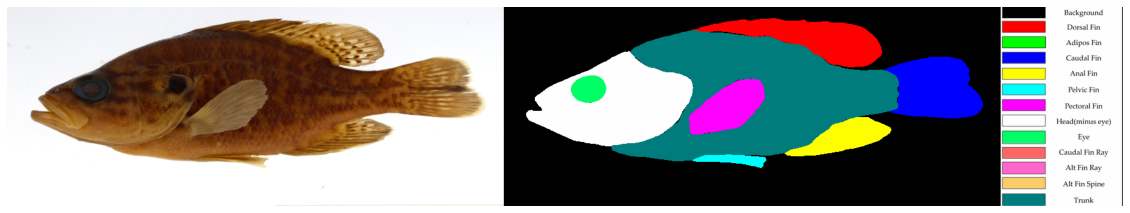

In [18]:
# Test the workflow for the first image of the list
image_name = image_name_list[0]
im_crop = get_cropped_image(image_dict, bbox_dict, image_name)
image_orig = Resize_img(im_crop)
image_preprocess = Preprocessing_single_image(im_crop)
pred_mask = Traits_prediction_one_image(image_preprocess)
montage =  Create_montage(pred_mask, image_orig)
print(image_name)
Visualize_montage(montage)


In [30]:
# Predict the batch
list_batch =[]
list_image_orig = []
for image_name in image_name_list[:5]:
    
    # Bounding box
    im_crop = get_cropped_image(image_dict, bbox_dict, image_name)
    # original image for montage
    image_orig = Resize_img(im_crop)
    list_image_orig.append(image_orig)
    # preprocess on image (normalization)
    image_preprocess = Preprocessing_single_image(im_crop)
    list_batch.append(image_preprocess)
    # Prediction
    
    

In [31]:
#arr= np.asarray(list_batch)
img_tensor = torch.as_tensor(list_batch).to(DEVICE)
img_tensor.shape

torch.Size([5, 3, 320, 800])

In [32]:
batch_res = Traits_prediction_batch(img_tensor)
batch_res.shape

(5, 12, 320, 800)

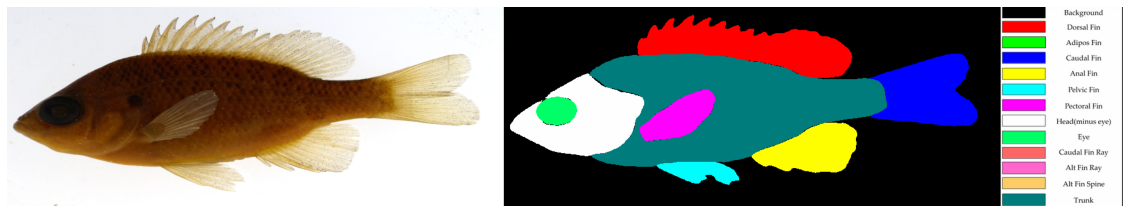

In [41]:
montage =  Create_montage(batch_res[4,:], list_image_orig[4])
Visualize_montage(montage)

# Predict the traits for each fish

The Result are store in variable named Result in form of a dictionary 

+ The keys are the name of the file 
+ The values are list of three element: 

    - pred_mask (array 12x800x32, each channel correspond to a traits)
    - bounding box [left, upper, width, height] 
    - montage original_image/traits segmentation with color-coded traits/ legend

In [114]:
# Predict the batch
Result ={}
for image_name in image_name_list[:5]:
    
    # Bounding box
    im_crop = get_cropped_image(image_dict, bbox_dict, image_name)
    # original image for montage
    image_orig = Resize_img(im_crop)
    # preprocess on image (normalization)
    image_preprocess = Preprocessing_single_image(im_crop)
    # Prediction
    pred_mask = Traits_prediction_one_image(image_preprocess)
    # Create the montage image [Original_image | Trait_segmentation | legend]
    montage =  Create_montage(pred_mask, image_orig)
    Result[image_name] = [pred_mask, bbox_dict[image_name], montage ]

# Display

To display the montage assign the display to True otherwise to False


In [93]:
# Display the result
def Display_one_fish(Result, fish_name):    
    
    pred_mask, bbox, montage = Result[fish_name]
    Visualize_montage(montage)
    print(image_name)
    

JFBM-FISH-0017057.jpg


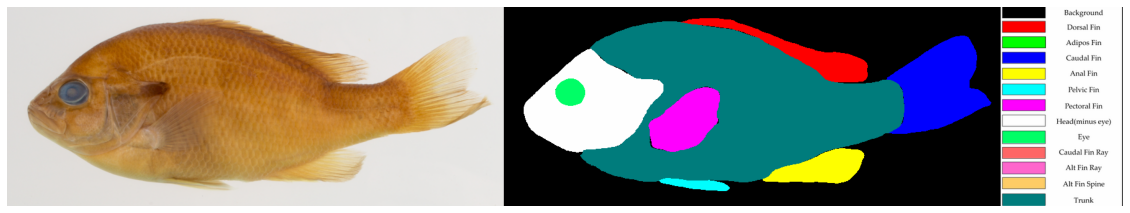

In [94]:
# Display one fish
# Choose the name of the fish you want to display
fish_name = 'JFBM-FISH-0014991.jpg'
Display_one_fish(Result, fish_name)

JFBM-FISH-0017057.jpg
JFBM-FISH-0017057.jpg
JFBM-FISH-0017057.jpg
JFBM-FISH-0017057.jpg
JFBM-FISH-0017057.jpg


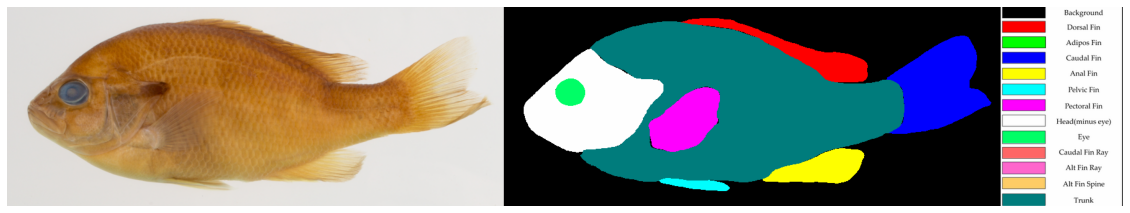

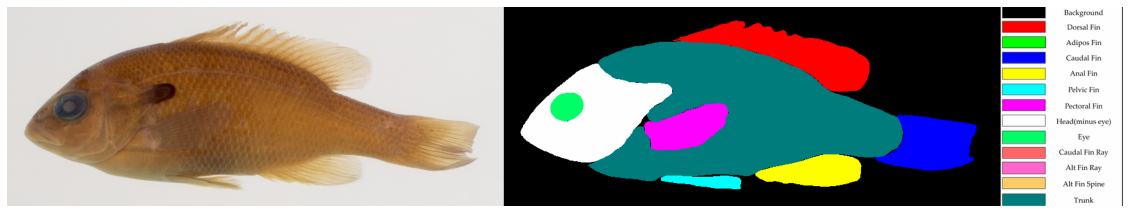

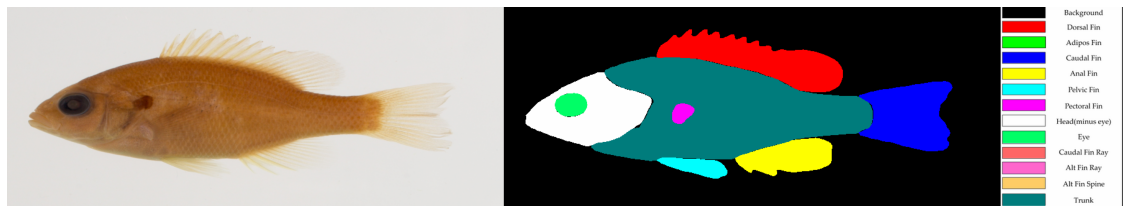

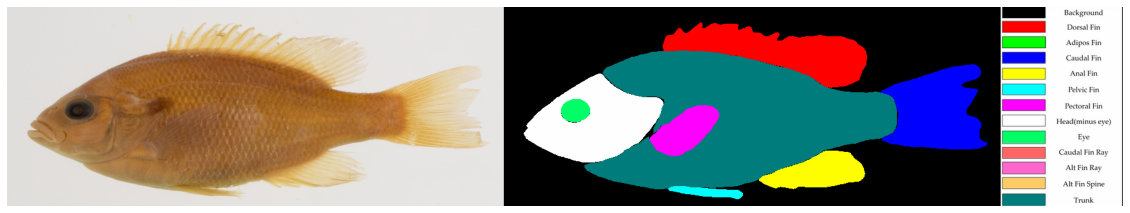

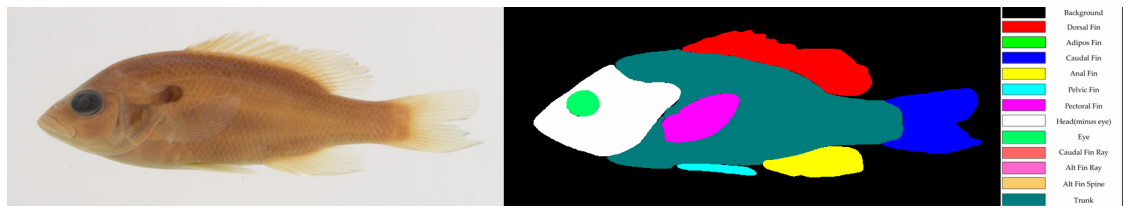

In [95]:
# Visualize the several images
# only display the 10 first fish
# You can choose a slice of the data by editing the start_number and max_number

start_number = 0
max_number = 10
for fish_name in list(Result.keys())[start_number:max_number]:
        
        Display_one_fish(Result, fish_name)
if len(Result.keys()) > max_number:
    print ('Only {:} fish out of {:} have been displayed'.format (max_number,len(Result.keys())))

# Save the image and montage

    1- Define the location to save the result
    2- Save prediction mask
    3- Save montage



In [ ]:
# Define location to save the prediction mask and montage
# Create a folder output: name = folder_input_name + _Output


Result_output_folder = os.path.join(folder_path,'_Output')
if not os.path.exists(Result_output_folder): 
    os.mkdir(Result_output_folder)
    
    

In [ ]:
# loop throught the files in the folder
for image_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path,image_name)
    predict_save(file_path,Result_output_folder)

In [24]:
# import for the image analysis using skimage

import matplotlib.pyplot as plt
import skimage
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter
from matplotlib.patches import Rectangle
from tqdm import tqdm



In [25]:
# define Label with trait name
chan_label_dict = {0: 'Dorsal_fin',
 1: 'Adipos_fin',
 2: 'Caudal Fin',
 3: 'Anal Fin',
 4: 'Pelvic Fin',
 5: 'Pectoral Fin',
 6: 'Head',
 7: 'Eye',
 8: 'Caudal Fin Ray',
 9: ' Alt Fin Ray',
 10: 'Alt Fin Spine',
 11: 'Trunk'}

In [26]:
# fucntions to measure the area (in pixel) for each trait and creation of a table

def Get_area_per_trait (pred_mask, name, properties =['area'], chan_label_dict=chan_label_dict):
    
    Area = {}
    Area ['name']= name
    
    for i in range(0,pred_mask.shape[0]):
    
        trait_name = chan_label_dict[i]
        chan_ = pred_mask[i,:,:].astype('int')
    
        if np.any(chan_!=0):
            #print(trait_name)
            blobs_ = label(chan_)
            Area[trait_name] = max((regionprops_table(blobs_, properties = properties)['area']))
        else :
             Area[trait_name] = 0
    
        #plt.figure()
        #plt.axis('off')
        #plt.imshow(chan_)
        
    return Area

def Create_trait_table(Results):
    df = pd.DataFrame()
    
    for file_name, output in Results.items():
        pred_mask, bbox, montage =output
        
        Area = Get_area_per_trait (pred_mask, file_name)
        output = pd.DataFrame()
        df= df.append(Area, ignore_index=True)
    return df
        

In [28]:
# Recreate the table and display the first line of the table
df = Create_trait_table(Result)
df.head()

name  Dorsal_fin  Adipos_fin  Caudal Fin  Anal Fin  \
0  Jfbm-Fish-0020379     10824.0         0.0     12599.0    4770.0   
1  Jfbm-Fish-0017057      6025.0         0.0      5316.0    2544.0   
2  Jfbm-Fish-0016965      5499.0         0.0      4852.0    2545.0   
3  Jfbm-Fish-0017768      9064.0         0.0      7363.0    4258.0   
4  Jfbm-Fish-0017128     14504.0         0.0     13837.0    6031.0   

   Pelvic Fin  Pectoral Fin     Head     Eye  Caudal Fin Ray   Alt Fin Ray  \
0      2176.0        4226.0  11328.0  1275.0             0.0           0.0   
1       701.0        2880.0   8588.0   764.0             0.0           0.0   
2       951.0           0.0   5151.0   625.0             0.0           0.0   
3       680.0        3771.0   9594.0  1100.0             0.0           0.0   
4      1495.0        5271.0  18529.0  1159.0             0.0           0.0   

   Alt Fin Spine    Trunk  
0            0.0  44013.0  
1            0.0  22541.0  
2            0.0  18274.0  
3            0.0  37703.0  
4            0.0  55153.0

In [64]:
# Save the table in a CSV
df.to_csv('table_trait.cvs',index=False)

# Section build the prediction script one image

Input : cropped image .jpg
output : segmented image .png


In [42]:
def predict_segmentation(image_path):
    '''
    input : image location
    ouput : segmented image in 
    '''
    img = Import_image (image_path)
    #resized_img = Resize_img(img, r_width = 800, r_height = 320 )
    image_preprocess = Preprocessing_single_image(img)
    
    # Prediction
    pred_mask = Traits_prediction_one_image(image_preprocess)
    
    return pred_mask


In [56]:
image_path = '/home/thibault/Documents/Project/BGNN_Snakemake/Cropped/INHS_FISH_79829_cropped.jpg'

mask_path_to_save = '/home/thibault/Documents/Project/BGNN_Snakemake/Cropped/INHS_FISH_79829_segmented.png'

In [57]:
os.path.exists(image_path)

True

In [58]:
pred_mask= predict_segmentation(image_path)

In [59]:

get_color_img(pred_mask, normal=False).save(mask_path_to_save)
